# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [30]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm

In [31]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths

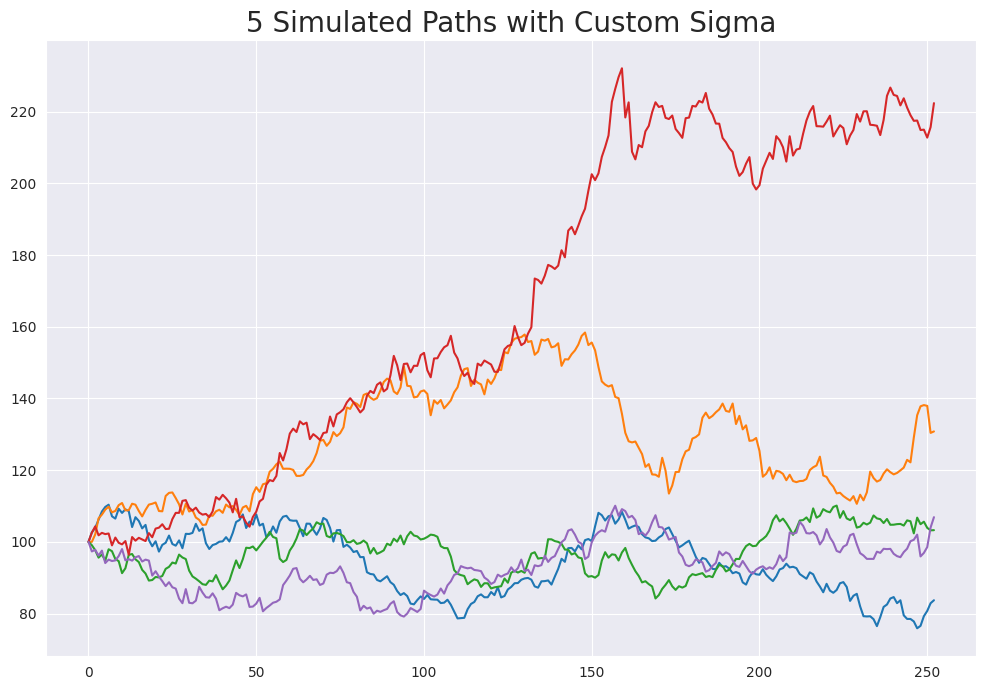

In [32]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

## Profit Distribution by delta-hedging the above stock path movements

Now, considering the stock price paths simulated earlier with varying volatility σ, we incorporate the instantaneous volatility to compute delta $(\Delta)$ dynamically at each hedging step. Hedging is performed at discrete time increments corresponding to the steps along each stock price path.

### Instantaneous $\Delta$ function

Since the stock evolution $S(t)$, is modeled to be using Black-Scholes model with log-return drift $\mu$ but with varying $\sigma$ for each stock paths step. Thus, the instantaneous $\Delta$ formulae at each step would be same as that of a European call option under Black-Scholes assumptions.

In [33]:
#Compute instantaneous delta expression for hedging at each stock path step using European call option under Black-Scholes assumptions
def delta_inst(S0, K, sigma, t, r):
    """

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Instantaneous Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)
    

### Premium cost

Let us assume, premium cost to be 10$ at t=0

In [34]:
# Set stock parameters

# Set strike price of the option
K = 95

# Initial stock price at time t=0
S0 = 100

# Time to maturity of the option in years
t = 1

# Risk-free interest rate (annualized)
r = 0.039

# Expected stock return (drift term in stock log-return model)
mu = 0.275

# Premium received per option sold 
premium = 10

# Number of options sold (size of the position)
num_options = 100

# Number of Monte Carlo simulation paths for generating stock price trajectories
n_p = 100000

# Number of discrete time steps or hedging intervals along each stock price path
n_h = 400

### Profit and Loss from Continous $\Delta$ Hedging for varying $\sigma$ stock path

In [35]:
#Function for simulated profit and loss (P&L) of delta hedging sold call options with stochastic volatility

def varying_call_hedge(n_hedges, n_paths):
    """
    Simulates profit and loss (P&L) of hedging a short call option position with stochastic volatility.
    
    Parameters:
        n_hedges (int): Number of hedging steps
        n_paths (int): Number of Monte Carlo simulation paths
        S0 (float): Initial stock price
        K (float): Strike price
        t (float): Time to maturity (years)
        r (float): Risk-free interest rate (annual)
        num_options (int): Number of call options sold
        mu (float): Expected drift of the stock in log-return model
        premium (float): Premium received per option sold
        
    Returns:
        pnl (np.ndarray): Array of P&L values from each simulation path
    """
    # Calculate time step size
    dt = t / n_hedges

    # Generate array of time remaining at each hedge step
    times = np.linspace(t - dt, 0, n_hedges)

    # Generate standard normal noise for each path and hedge step
    noise = np.random.normal(0, 1, size=(n_paths, n_hedges))

    # Stochastic volatility sampled from discrete distribution
    sigma = np.random.choice([0.2, 0.3, 0.45], p=[0.5, 0.3, 0.2], size=(n_paths, n_hedges))

    # Calculate increments of log returns
    increments = (mu + r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * noise
    
    # Compute cumulative log returns at each step
    log_returns = np.cumsum(increments, axis=1)
    
    # Calculate stock price paths
    paths = S0 * np.exp(log_returns)
    
    # Insert initial stock price at time zero
    S_paths = np.insert(paths, 0, S0, axis=1)
    
    # Initialize list to store discounted stock profits from hedging steps
    discounted_stock_profits = []
    
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt
        sigma_i = sigma[:, i]

        # Compute instantaneous delta for each path at hedge step
        delta = delta_inst(S_start, K, sigma_i, tte, r)
        
        # Calculate discounted stock profit over hedge interval
        stock_profit = np.exp(-r * (i * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        
        discounted_stock_profits.append(stock_profit)
    
    # Sum all discounted profits over hedge intervals for each path
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)
    
    # Stock price at maturity for each path
    S_end = S_paths[:, -1]
    
    # Calculate discounted call payouts at maturity
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)
    
    # Calculate overall pnl for each path (premium received - payouts + hedging profits)
    pnl = num_options * (premium - call_payouts + total_stock_profit)
    
    return pnl

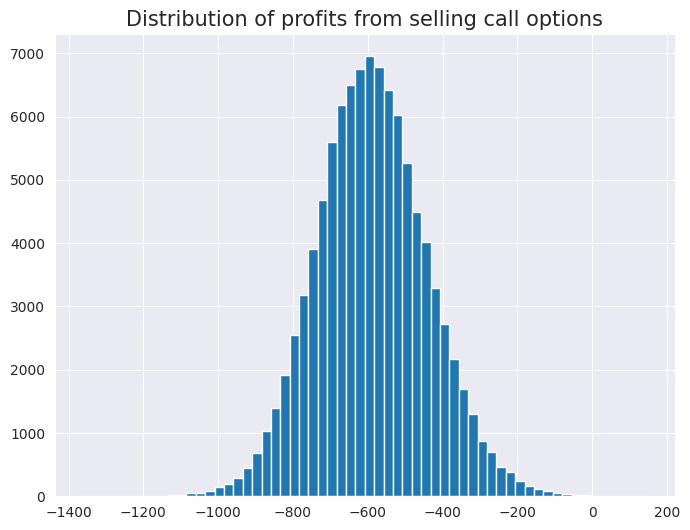

In [36]:
plt.figure(figsize = (8,6))
plt.hist(varying_call_hedge(n_h, n_p),bins = 60)
plt.title('Distribution of profits from selling call options', size = 15)

plt.show()

In [37]:
#Print data

pnl = varying_call_hedge(n_h, n_p)

expected_profit = np.mean(pnl)

std_error = np.std(pnl) / np.sqrt(n_paths)

max_loss = np.min(pnl)

max_profit = np.max(pnl)

print(f'Expected profit: ${expected_profit: .2f}')

print('----'*20)
print('----'*20)

print(f'Standard Error: ${std_error}')

print('----'*20)
print('----'*20)

print(f'Max Loss: ${max_loss:.2f}')

print('----'*20)
print('----'*20)

print(f'Max Profit: ${max_profit: .2f}')

print('----'*20)
print('----'*20)

Expected profit: $-587.39
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Error: $66.3939245556277
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Loss: $-1353.55
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Profit: $ 128.80
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


### Profit and Loss from $\Delta$ Hedging for fixed $\sigma$ stock path (i.e. European call option under Black-Scholes assumptions)

In [38]:
#Function for simulated profit and loss (P&L) of delta hedging sold call options with constant volatility

def constant_call_hedge(n_hedges, n_paths, sigma):
    """
    Simulate P&L of hedging a short call option position with constant volatility.
    
    Parameters:
        n_hedges (int): Number of hedge steps
        n_paths (int): Number of simulated stock price paths
        mu (float): Expected drift in stock returns
        S0 (float): Initial stock price
        K (float): Strike price
        t (float): Time to maturity (years)
        r (float): Risk-free interest rate
        sigma (float): Constant volatility
        num_options (int): Number of options sold
        premium (float): Premium received per option
        delta_inst (function): Function to calculate delta: delta_inst(S, K, sigma, tte, r)
    
    Returns:
        pnl (np.ndarray): Array of P&L outcomes for each path
    """
    # Calculate time step size and discrete times for hedging
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)
    
    # Generate normal random noise for paths and steps
    noise = np.random.normal(0, 1, size=(n_paths, n_hedges))
    
    # Calculate increments of log-returns
    increments = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise
    
    # Cumulative log-returns per path
    log_returns = np.cumsum(increments, axis=1)
    
    # Simulated stock price paths
    paths = S0 * np.exp(log_returns)
    
    # Insert initial stock price at time zero for each path
    S_paths = np.insert(paths, 0, S0, axis=1)
    
    discounted_stock_profits = []
    
    # Calculate discounted profits from hedging for each interval
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt  # Time to expiration at hedge
        
        # Calculate delta for each path at this hedge
        delta = delta_inst(S_start, K, sigma, tte, r)
        
        # Compute discounted stock profit for hedge interval
        stock_profit = np.exp(-r * (i * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)
    
    # Sum profits across all hedge intervals for each path
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)
    
    # Calculate discounted call payouts at maturity
    S_end = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)
    
    # Calculate P&L for each path
    pnl = num_options * (premium - call_payouts + total_stock_profit)
    
    return pnl

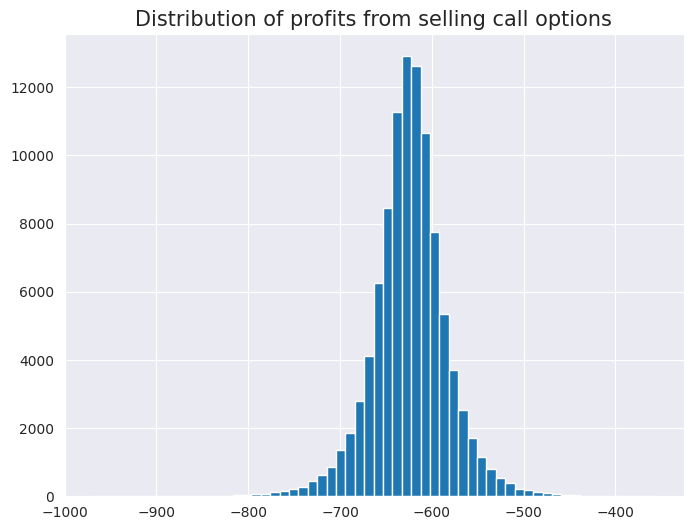

In [39]:
#Visualising Profit/ Loss distribution
result = constant_call_hedge(n_h, n_p,0.3)
plt.figure(figsize = (8,6))
plt.hist(result,bins = 60)
plt.title('Distribution of profits from selling call options', size = 15)

plt.show()

In [40]:
#Print data

pnl = constant_call_hedge(n_h, n_p,0.3)
expected_profit = np.mean(pnl)

std_error = np.std(pnl) / np.sqrt(n_paths)

max_loss = np.min(pnl)

max_profit = np.max(pnl)

print(f'Expected profit: ${expected_profit: .2f}')

print('----'*20)
print('----'*20)

print(f'Standard Error: ${std_error}')

print('----'*20)
print('----'*20)

print(f'Max Loss: ${max_loss:.2f}')

print('----'*20)
print('----'*20)

print(f'Max Profit: ${max_profit: .2f}')

print('----'*20)
print('----'*20)

Expected profit: $-624.28
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Error: $18.226302325498754
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Loss: $-967.89
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Profit: $-359.74
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


## Observations and Remarks

We plot and show results for delta hedging sold call option for both varying volatility, $\sigma$, as well as for constant $\sigma$. We also take 2 cases where, we do $\Delta$ hedging only 5 and 100 times. 

#### For constant $\sigma$ case (hedging 100 times)

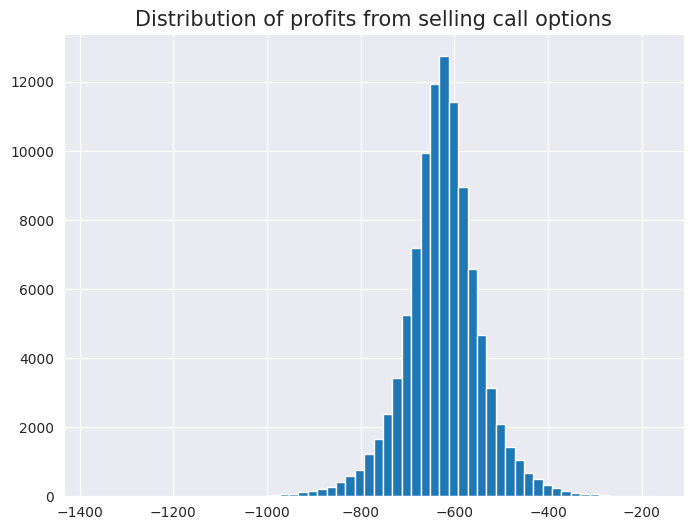

Expected profit: $-626.20
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Error: $36.37222156901825
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Loss: $-1373.84
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Profit: $-171.12
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [41]:
# Volatiliy, sigma=0.3
n_h=100

pnl=constant_call_hedge(n_h, n_p,0.3)

plt.figure(figsize = (8,6))
plt.hist(pnl,bins = 60)
plt.title('Distribution of profits from selling call options', size = 15)

plt.show()

expected_profit = np.mean(pnl)

std_error = np.std(pnl) / np.sqrt(n_paths)

max_loss = np.min(pnl)

max_profit = np.max(pnl)

print(f'Expected profit: ${expected_profit: .2f}')

print('----'*20)
print('----'*20)

print(f'Standard Error: ${std_error}')

print('----'*20)
print('----'*20)

print(f'Max Loss: ${max_loss:.2f}')

print('----'*20)
print('----'*20)

print(f'Max Profit: ${max_profit: .2f}')

print('----'*20)
print('----'*20)

#### For Varying $\sigma$ (hedging 100 times)

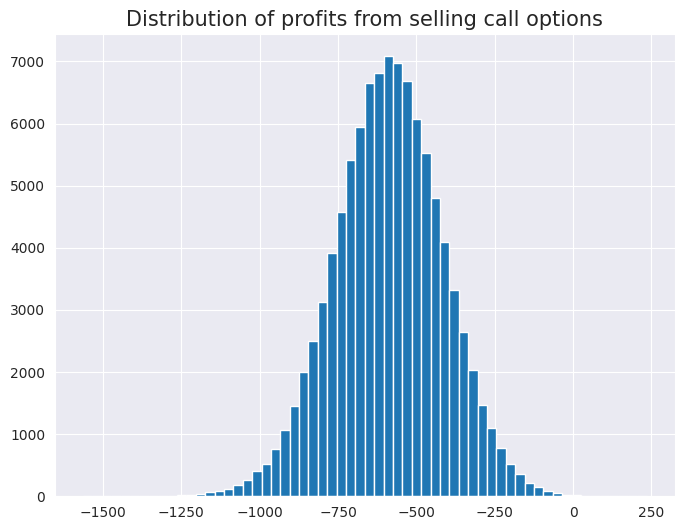

Expected profit: $-589.12
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Error: $77.4468659834476
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Loss: $-1563.76
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Profit: $ 234.78
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [42]:

n_h=100

pnl=varying_call_hedge(n_h, n_p)

plt.figure(figsize = (8,6))
plt.hist(pnl,bins = 60)
plt.title('Distribution of profits from selling call options', size = 15)

plt.show()

expected_profit = np.mean(pnl)

std_error = np.std(pnl) / np.sqrt(n_paths)

max_loss = np.min(pnl)

max_profit = np.max(pnl)

print(f'Expected profit: ${expected_profit: .2f}')

print('----'*20)
print('----'*20)

print(f'Standard Error: ${std_error}')

print('----'*20)
print('----'*20)

print(f'Max Loss: ${max_loss:.2f}')

print('----'*20)
print('----'*20)

print(f'Max Profit: ${max_profit: .2f}')

print('----'*20)
print('----'*20)

#### For constant $\sigma$ case (hedging 5 times)

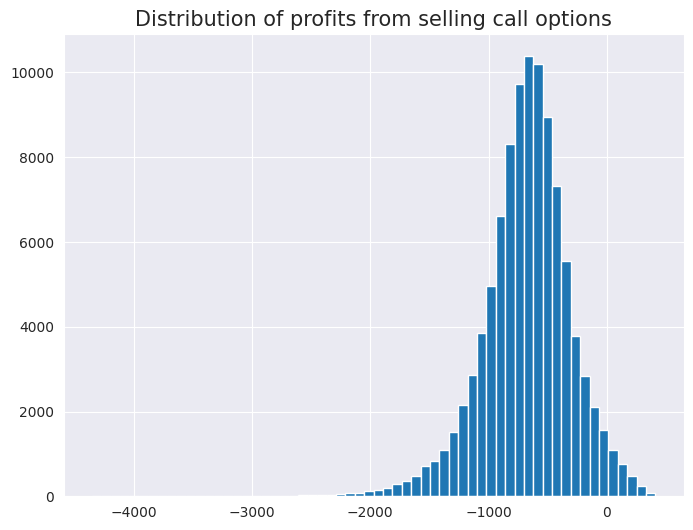

Expected profit: $-681.67
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Error: $167.36208940663016
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Loss: $-4354.57
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Profit: $ 410.44
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [43]:
# Volatiliy, sigma=0.3
n_h=5

pnl=constant_call_hedge(n_h, n_p,0.3)

plt.figure(figsize = (8,6))
plt.hist(pnl,bins = 60)
plt.title('Distribution of profits from selling call options', size = 15)

plt.show()

expected_profit = np.mean(pnl)

std_error = np.std(pnl) / np.sqrt(n_paths)

max_loss = np.min(pnl)

max_profit = np.max(pnl)

print(f'Expected profit: ${expected_profit: .2f}')

print('----'*20)
print('----'*20)

print(f'Standard Error: ${std_error}')

print('----'*20)
print('----'*20)

print(f'Max Loss: ${max_loss:.2f}')

print('----'*20)
print('----'*20)

print(f'Max Profit: ${max_profit: .2f}')

print('----'*20)
print('----'*20)

#### For Varying $\sigma$ (hedging 5 times)

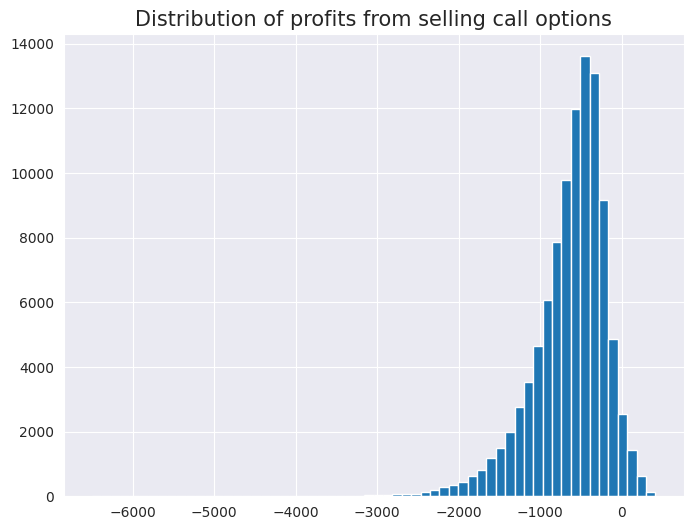

Expected profit: $-638.67
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Error: $204.0983511571988
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Loss: $-6503.16
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Max Profit: $ 411.90
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [44]:
# Volatiliy, sigma=0.3
n_h=5

pnl=varying_call_hedge(n_h, n_p)

plt.figure(figsize = (8,6))
plt.hist(pnl,bins = 60)
plt.title('Distribution of profits from selling call options', size = 15)

plt.show()

expected_profit = np.mean(pnl)

std_error = np.std(pnl) / np.sqrt(n_paths)

max_loss = np.min(pnl)

max_profit = np.max(pnl)

print(f'Expected profit: ${expected_profit: .2f}')

print('----'*20)
print('----'*20)

print(f'Standard Error: ${std_error}')

print('----'*20)
print('----'*20)

print(f'Max Loss: ${max_loss:.2f}')

print('----'*20)
print('----'*20)

print(f'Max Profit: ${max_profit: .2f}')

print('----'*20)
print('----'*20)

## Conclusion:



The results indicate that increasing the hedging frequency (from 5 to 100 times) significantly reduces both the expected loss and the variability (standard error) of the profit and loss (P&L) from selling a call option, for both constant and varying volatility scenarios.

- **Constant Volatility:**  
  Hedging more frequently markedly improves risk control, reducing the magnitude of the expected loss and drastically lowering the standard error and maximum loss. However, even with frequent hedging, losses persist, indicating imperfect hedging under this model.

- **Varying Volatility:**  
  Similar trends are observed, but the presence of stochastic volatility results in higher uncertainty and larger potential losses at lower hedging frequencies. Increasing the hedge frequency decreases expected loss and volatility, though the max loss remains larger than in the constant volatility case, reflecting additional risks introduced by volatility fluctuations.

